## Подготовка

In [1]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import pandas as pd
import pythonUtils.config as config
import pythonUtils.drawing as drawing
import pythonUtils.metrics as metrics

In [2]:
s = config.get_s()
train_dataset = torch.load(f"datasets/train{s}.pt")
test_dataset = torch.load(f"datasets/test{s}.pt")
result_dataset = torch.load(f"datasets/predict{s}.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
train_dataloader_1 = torch.utils.data.DataLoader(train_dataset)
train_dataloader_out = torch.utils.data.DataLoader(train_dataset, batch_size= len(train_dataset))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_dataloader_1 = torch.utils.data.DataLoader(test_dataset)
test_dataloader_out = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset))
result_dataloader_1 = torch.utils.data.DataLoader(result_dataset)

In [3]:
class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 10, stride=2),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 7, stride=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 7, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 4, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 4, stride=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 4, stride=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.Sigmoid(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(256, 512, 2, stride=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 18)
        ) 
    def forward(self, x):
        return self.model(x)


In [4]:
num_epochs = 60
learning_rate = 8e-4
weight_decay = 0.1
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
loss_history = []
epoch_loss_history = []

## Обучение

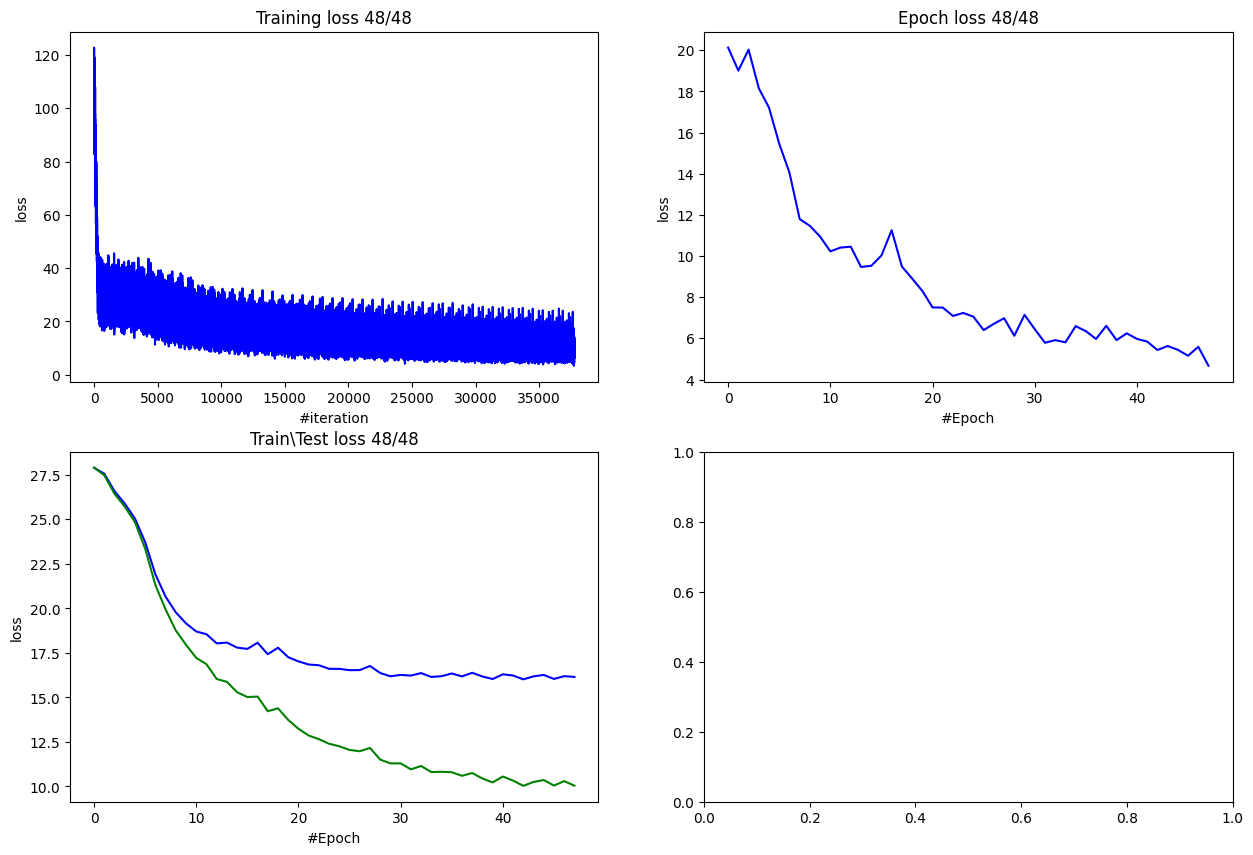

1/48 current loss: 20.126148223876953
2/48 current loss: 19.01012420654297
3/48 current loss: 20.029417037963867
4/48 current loss: 18.152055740356445
5/48 current loss: 17.209304809570312
6/48 current loss: 15.45418643951416
7/48 current loss: 14.053183555603027
8/48 current loss: 11.796209335327148
9/48 current loss: 11.464835166931152
10/48 current loss: 10.943273544311523
11/48 current loss: 10.22815227508545
12/48 current loss: 10.411905288696289
13/48 current loss: 10.45323371887207
14/48 current loss: 9.46973991394043
15/48 current loss: 9.524202346801758
16/48 current loss: 10.027057647705078
17/48 current loss: 11.254302024841309
18/48 current loss: 9.490462303161621
19/48 current loss: 8.90783405303955
20/48 current loss: 8.304898262023926
21/48 current loss: 7.502963542938232
22/48 current loss: 7.496976852416992
23/48 current loss: 7.088431358337402
24/48 current loss: 7.2358245849609375
25/48 current loss: 7.051797866821289
26/48 current loss: 6.400789260864258
27/48 curre

In [5]:
calculate_train_mae = True
train_mae = []
test_mae = []
for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)
        
        loss = criterion(predictions, y_batch)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad() 

        loss_history.append(loss.item())
    epoch_loss_history.append(loss.item())
    fig, axs = plt.subplots(nrows= 2, ncols= 2,  figsize=(15,10))
    display.clear_output(wait=True)

    axs[0,0].set_title(f"Training loss {i+1}/{num_epochs}")
    axs[0,0].set_xlabel("#iteration")
    axs[0,0].set_ylabel("loss")
    axs[0,0].plot(loss_history, 'b')
    
    axs[0,1].set_title(f"Epoch loss {i+1}/{num_epochs}")
    axs[0,1].set_xlabel("#Epoch")
    axs[0,1].set_ylabel("loss")
    axs[0,1].plot(epoch_loss_history, 'b')

    test_mae.append(metrics.mae(test_dataloader_out, model))
    axs[1,0].set_title(f"Test loss {i+1}/{num_epochs}")
    axs[1,0].set_xlabel("#Epoch")
    axs[1,0].set_ylabel("loss")
    axs[1,0].plot(test_mae, 'b', label = 'test')

    if calculate_train_mae:
        train_mae.append(metrics.mae(train_dataloader_out, model))

        axs[1,0].set_title(f"Train\Test loss {i+1}/{num_epochs}")
        axs[1,0].plot(train_mae, 'g', label = 'train')

    plt.show()

    for i in range(len(epoch_loss_history)):
        print(f'{i+1}/{num_epochs} current loss: {epoch_loss_history[i]}') 
torch.save(model.state_dict, 'weights/CatNet.pth')

In [6]:
model = CatNet(16, 18)
model.load_state_dict(torch.load('weights/CatNet.pth')())
model.eval()
""

''

## Оценка

In [7]:
print(f"MAE on train data : {metrics.mae(train_dataloader_out, model)}")
print(f"MAE on test data : {metrics.mae(test_dataloader_out, model)}")

MAE on train data : 10.431346374707653
MAE on test data : 16.599378343154886


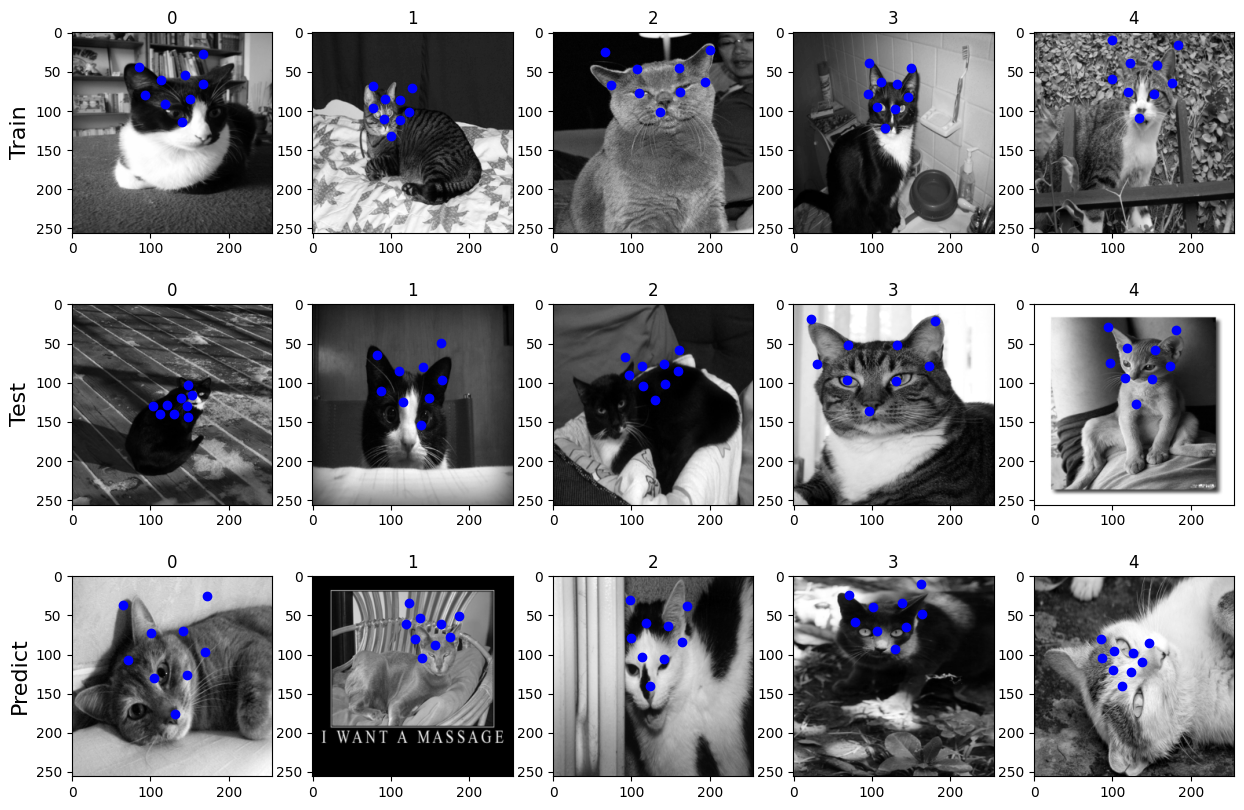

In [8]:
fig, axs = plt.subplots(nrows= 3 , ncols= 5,  figsize=(15,10))
drawing.draw_pred_line(axs, train_dataset, model, 'Train', 0, 5)
drawing.draw_pred_line(axs, test_dataset, model, 'Test', 1, 5)
drawing.draw_pred_line(axs, result_dataset, model, 'Predict', 2, 5)

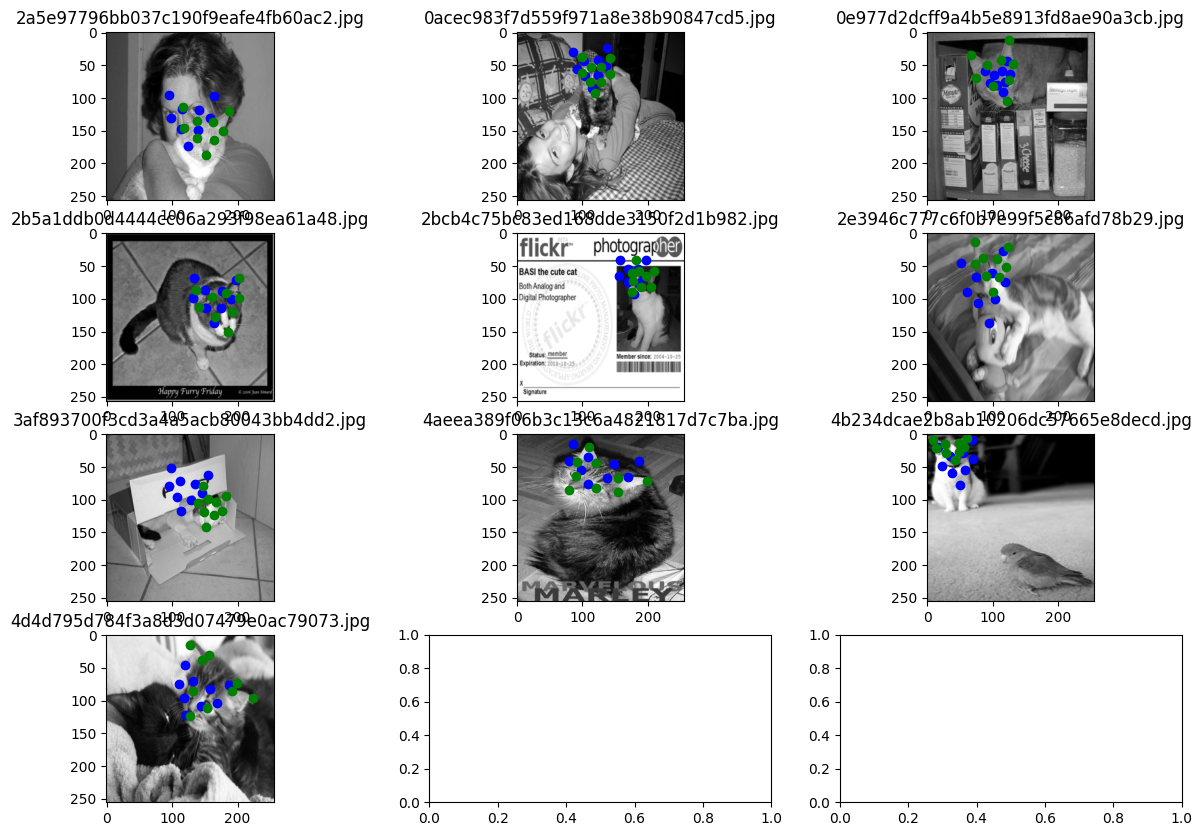

In [9]:
#from pythonUtils.drawing import draw_img_by_name
from pythonUtils.config import intresting_pictures
fig, axs = plt.subplots(nrows= (len(intresting_pictures)//3)+1, ncols= 3,  figsize=(15,10))

for i in range(len(intresting_pictures)):
    drawing.draw_img_by_name(intresting_pictures[i], model, axs[i//3,i%3])

## Подсчет результатов

In [10]:
pred = []
for x in result_dataloader_1:
    preds = model.forward(x[0])
    pred.append(preds[0].tolist())
predSizesNames = pd.read_csv('datasets/predictSizez&names.csv')

In [11]:
columns = pd.read_csv('train_labels.csv').columns
result = pd.DataFrame(columns=columns)
for row in range(len(pred)):
    width = predSizesNames.loc[row,'0']
    height = predSizesNames.loc[row,'0']
    for i in range(0, len(pred[row]),2):
            pred[row][i] = pred[row][i]*(width/config.size)
            pred[row][i+1] = pred[row][i+1]*(height/config.size)
for row in range(len(pred)):
    result.loc[-1] = pred[row]+[predSizesNames.loc[row,'2']]
    result.index = result.index + 1
    result = result.sort_index()
result = result.rename(columns={"file_name":"file_names"})
result.to_csv('results/result.csv',index=False)